In [64]:
"""Verify the gradient derivation of linear masked autoencoder."""
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import numpy as np
import pandas as pd 
import scipy.stats as stats

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [66]:
# set default to be float64
torch.set_default_dtype(torch.float64)

### Model initialisation

In [67]:
# Linear auto-encoder model
class LAE(nn.Module):
    def __init__(self, n, p):
        super(LAE, self).__init__()
        self.n = n
        self.p = p
        self.w1 = nn.Linear(n, p, bias=False)
        self.w2 = nn.Linear(p, n, bias=False)

    def forward(self, y):
        y = self.w1(y)
        y = self.w2(y)
        return y

In [68]:
## Masked lienar auto-encoder model
# Define different types of masks
def mask_basic(prob, sample_num, feature_num):
    return torch.zeros(sample_num, feature_num).bernoulli_(prob)

def mask_dropping_probs(prob_list: torch.Tensor, sample_num, feature_num):
    return torch.zeros(sample_num, feature_num).bernoulli_(prob_list)

def mask_patches(prob, patch_size: torch.Tensor, sample_num, sample_dim: torch.Tensor):
    feature_num = sample_dim[0]*sample_dim[1]
    div_check = sample_dim % patch_size == torch.zeros(2)
    if torch.all(div_check):
        pix_num = torch.div(sample_dim, patch_size, rounding_mode='floor')
        mat_patches = torch.zeros(sample_num, *pix_num).bernoulli_(prob)
        mat_patches = torch.repeat_interleave(mat_patches, patch_size[1], dim=2)
        return mat_patches.repeat_interleave(patch_size[0], dim=1).view(sample_num, feature_num)
    else:
        raise NotImplementedError(f"Both height ({sample_dim[0]}) and width ({sample_dim[1]}) should be divisible by patch_size ({patch_size}).")


# Masked autoencoder (linear)
class M_LAE(nn.Module):
    def __init__(self, prob, sample_dim, reduction_dim, type='basic', patch_size=None):
        super(M_LAE, self).__init__()
        self.prob = prob
        self.sample_dim = sample_dim
        self.H, self.W = sample_dim
        self.n = self.H * self.W
        self.p = reduction_dim
        if type not in ['basic', 'probs', 'patches']:
            raise NotImplementedError("Could only implement 'basic', 'probs' and 'patches' type of masking.")
        else:
            self.masking_type = type
        if patch_size is not None:
            self.patch_size = patch_size
        w1 = nn.Linear(self.n, self.p, bias=False)
        w2 = nn.Linear(self.p, self.n, bias=False)
        self.body = nn.Sequential(*[w1, w2])
    
    def forward(self, X, mask=None):
        m = X.shape[0]
        if mask is None:
            if self.masking_type == 'basic':
                mask = mask_basic(self.prob, m, self.n).to(device)
            elif self.masking_type == 'probs':
                mask = mask_dropping_probs(self.prob, m, self.n).to(device)
            elif self.masking_type == 'patches':
                mask = mask_patches(self.prob, self.patch_size, m, self.sample_dim).to(device)
        Y = mask * X
        Y = self.body(Y)
        return Y

In [69]:
class FE_Net(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(FE_Net, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.theta = nn.Linear(in_dim, out_dim, bias=False)

    def forward(self, W):
        return self.theta(W)

In [70]:
def train_loop(data_dict, model, criterion, optimizer, type, epochs=10, sample_average=10, record=True):
    train_loss = []
    val_loss = []
    if type=='encoder':
        train_inputs = data_dict['train_inputs']
        train_targets = train_inputs
    elif type=='fe':
        train_inputs = data_dict['train_inputs']
        train_targets = data_dict['train_targets']
        sample_average = 1

    for epoch in range(epochs+1):
        loss_total = 0
        optimizer.zero_grad()
        for i in range(sample_average):
            train_outputs = model(train_inputs)
            loss = criterion(train_outputs, train_targets)
            loss_total += loss
        loss_total /= sample_average
        loss_total.backward()
        optimizer.step()
        if record:
          train_loss.append(loss_total.item())
          if epochs>=5 and epoch%(epochs//5)==0:
              v_loss = test_loop(data_dict, model, criterion, type)
              val_loss.append(v_loss)
              print('epoch: ', epoch, ', train loss: ', loss.item(), ', val loss', v_loss)
    if record:
        return {'train_loss': train_loss, 'val_loss': val_loss}
    else:
        return loss_total.item()

def test_loop(data_dict, model, criterion, type):
    if type=='encoder':
        val_inputs = data_dict['val_inputs']
        val_targets = val_inputs
    elif type=='fe':
        val_inputs = data_dict['val_inputs']
        val_targets = data_dict['val_targets']

    with torch.no_grad():
        val_outputs = model(val_inputs)
        loss = criterion(val_outputs, val_targets)
    return loss.item()

In [71]:
# feature extraction
def feature_extraction(data_dict, model_parameters, criterion, type, epochs=200, device='cuda'):
    train_inputs, train_targets, val_inputs, val_targets = data_dict.values()

    params = list(model_parameters)
    W1 = params[0].clone().detach()
    train_inputs_fe = train_inputs @ W1.T
    val_inputs_fe = val_inputs @ W1.T
    reduction_dim = train_inputs_fe.shape[1]
    target_dim = train_targets.shape[1]

    if type=='ls':
        param_fe = (torch.inverse(train_inputs_fe.T@train_inputs_fe) @ train_inputs_fe.T @ train_targets).T
        loss = criterion(val_targets, val_inputs_fe @ param_fe.T)
        return loss.item()
    elif type=='gd':
        data_dict_fe = {'train_inputs': train_inputs_fe, 'train_targets': train_targets,
                        'val_inputs': val_inputs_fe, 'val_targets': val_targets}
        net_fe = FE_Net(reduction_dim, target_dim).to(device)
        param_fe = list(net_fe.parameters())
        optimizer = optim.Adam(param_fe, lr=0.0001)
        ### TRAINING ###
        loss_fe = train_loop(data_dict_fe, net_fe, criterion, optimizer, epochs=epochs, record=False, type='fe')
        return loss_fe

### Dataset

In [72]:
train_num = 50
val_num = 20
H = 8
W = 8
sample_dim = torch.tensor([H, W])
feature_num = H * W
reduction_dim = feature_num
target_dim = feature_num * 2

prob = 0.75
prob_list = torch.rand(feature_num)*0.2 + 0.65
patch_size = torch.div(sample_dim, 2, rounding_mode='floor')

train_inputs = torch.rand(train_num, feature_num) * 2
train_inputs = train_inputs.to(device)
train_targets = torch.rand(train_num, target_dim)
train_targets = train_targets.to(device)
val_inputs = torch.rand(val_num, feature_num) * 2
val_inputs = val_inputs.to(device)
val_targets = torch.rand(val_num, target_dim)
val_targets = val_targets.to(device)
data_dict = {'train_inputs': train_inputs, 'train_targets': train_targets,
             'val_inputs': val_inputs, 'val_targets': val_targets}

fe_loss_dict = {'LAE': [], 'MLAE_basic': [], 'MLAE_probs': [], 'MLAE_patches': []}

In [73]:
learning_rate = 0.01
epochs = 500
epochs_fe = 250

### Get features from autoencoder

##### Linear autoencoder

In [74]:
for i in tqdm(range(epochs_fe)):
    net_LAE = LAE(feature_num, reduction_dim).to(device)

    params = list(net_LAE.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    if i==0:
        loss_LAE = train_loop(data_dict, net_LAE, criterion, optimizer, epochs=epochs, record=True, type='encoder')
    else:
        train_loop(data_dict, net_LAE, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_LAE.parameters(), criterion, type='ls', epochs=epochs)
    loss_gd = feature_extraction(data_dict, net_LAE.parameters(), criterion, type='gd', epochs=epochs)
    fe_loss_dict['LAE'].append(loss_gd)

  0%|          | 0/250 [00:00<?, ?it/s]

epoch:  0 , train loss:  1.5040675436191435 , val loss 1.0129898911416988
epoch:  100 , train loss:  0.024103525059242896 , val loss 0.18663444623709302
epoch:  200 , train loss:  0.00554298181478905 , val loss 0.14819946779660004
epoch:  300 , train loss:  0.0023803326821045675 , val loss 0.13149567376381768
epoch:  400 , train loss:  0.0012348920474564004 , val loss 0.12177367999307775
epoch:  500 , train loss:  0.000761437519027676 , val loss 0.11313063598774425


100%|██████████| 250/250 [06:10<00:00,  1.48s/it]


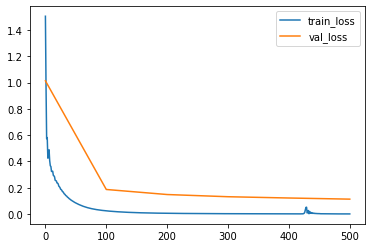

In [75]:
plt.plot(loss_LAE['train_loss'])
plt.plot(range(0, epochs+1, epochs//5), loss_LAE['val_loss'])
plt.legend(loss_LAE.keys())

##### Masked linear autoencoder (basic)

In [76]:
for i in tqdm(range(epochs_fe)):
    net_MLAE_basic = M_LAE(prob, sample_dim, reduction_dim).to(device)

    params = list(net_MLAE_basic.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    if i==0:
        loss_MLAE_basic = train_loop(data_dict, net_MLAE_basic, criterion, optimizer, epochs=epochs, record=True, type='encoder')
    else:
        train_loop(data_dict, net_MLAE_basic, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_MLAE_basic.parameters(), criterion, type='ls', epochs=epochs)
    loss_gd = feature_extraction(data_dict, net_MLAE_basic.parameters(), criterion, type='gd', epochs=epochs)
    fe_loss_dict['MLAE_basic'].append(loss_gd)

  0%|          | 0/250 [00:00<?, ?it/s]

epoch:  0 , train loss:  1.3832843840251496 , val loss 0.7535310545811527
epoch:  100 , train loss:  0.13958642019891085 , val loss 0.28061714437692936
epoch:  200 , train loss:  0.1499192677790504 , val loss 0.2711413058296914
epoch:  300 , train loss:  0.13423327937455806 , val loss 0.2719894507890348
epoch:  400 , train loss:  0.13455615937264706 , val loss 0.2717457267107883
epoch:  500 , train loss:  0.14841868952123904 , val loss 0.2687559546224505


100%|██████████| 250/250 [08:14<00:00,  1.98s/it]


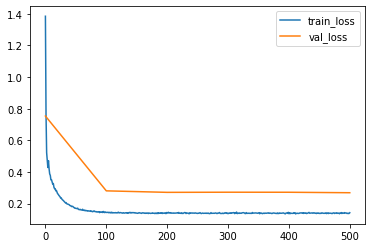

In [77]:
plt.plot(loss_MLAE_basic['train_loss'])
plt.plot(range(0, epochs+1, epochs//5), loss_MLAE_basic['val_loss'])
plt.legend(loss_MLAE_basic.keys())

##### Masked linear autoencoder (probs)

In [78]:
for i in tqdm(range(epochs_fe)):
    net_MLAE_probs = M_LAE(prob_list, sample_dim, reduction_dim, type='probs').to(device)

    params = list(net_MLAE_probs.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    if i==0:
        loss_MLAE_probs = train_loop(data_dict, net_MLAE_probs, criterion, optimizer, epochs=epochs, record=True, type='encoder')
    else:
        train_loop(data_dict, net_MLAE_probs, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_MLAE_probs.parameters(), criterion, type='ls', epochs=epochs)
    loss_gd = feature_extraction(data_dict, net_MLAE_probs.parameters(), criterion, type='gd', epochs=epochs)
    fe_loss_dict['MLAE_probs'].append(loss_gd)

  0%|          | 0/250 [00:00<?, ?it/s]

epoch:  0 , train loss:  1.4574535057134688 , val loss 0.8794383991195652
epoch:  100 , train loss:  0.15235075034795814 , val loss 0.28043668849216463
epoch:  200 , train loss:  0.1401041495731016 , val loss 0.26973850370105174
epoch:  300 , train loss:  0.14289246638580633 , val loss 0.2718129612487414
epoch:  400 , train loss:  0.1431874662205643 , val loss 0.26448547560748015
epoch:  500 , train loss:  0.13769640331880634 , val loss 0.25872253986478694


100%|██████████| 250/250 [09:09<00:00,  2.20s/it]


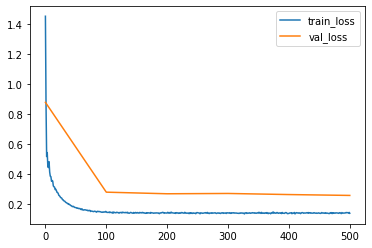

In [79]:
plt.plot(loss_MLAE_probs['train_loss'])
plt.plot(range(0, epochs+1, epochs//5), loss_MLAE_probs['val_loss'])
plt.legend(loss_MLAE_probs.keys())

##### Masked linear autoencoder (patches)

In [80]:
for i in tqdm(range(epochs_fe)):
    net_MLAE_patches = M_LAE(prob, sample_dim, reduction_dim, type='patches', patch_size=patch_size).to(device)

    params = list(net_MLAE_patches.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    if i==0:
        loss_MLAE_patches = train_loop(data_dict, net_MLAE_patches, criterion, optimizer, epochs=epochs, record=True, type='encoder')
    else:
        train_loop(data_dict, net_MLAE_patches, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_MLAE_patches.parameters(), criterion, type='ls', epochs=epochs)
    loss_gd = feature_extraction(data_dict, net_MLAE_patches.parameters(), criterion, type='gd', epochs=epochs)
    fe_loss_dict['MLAE_patches'].append(loss_gd)

  0%|          | 0/250 [00:00<?, ?it/s]

epoch:  0 , train loss:  1.3715282578205432 , val loss 0.7896469827520292
epoch:  100 , train loss:  0.15153138269946628 , val loss 0.3736562294920554
epoch:  200 , train loss:  0.140122972231874 , val loss 0.24209400863255193
epoch:  300 , train loss:  0.11083121166151232 , val loss 0.26070691281829583
epoch:  400 , train loss:  0.15968584338548197 , val loss 0.3013801180459122
epoch:  500 , train loss:  0.15694479091074554 , val loss 0.2514677346530633


100%|██████████| 250/250 [11:26<00:00,  2.75s/it]


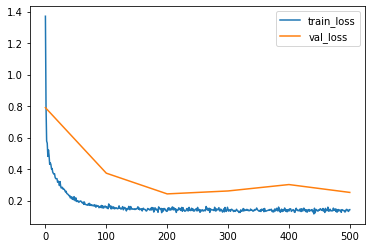

In [81]:
plt.plot(loss_MLAE_patches['train_loss'])
plt.plot(range(0, epochs+1, epochs//5), loss_MLAE_patches['val_loss'])
plt.legend(loss_MLAE_patches.keys())

### Evaluation

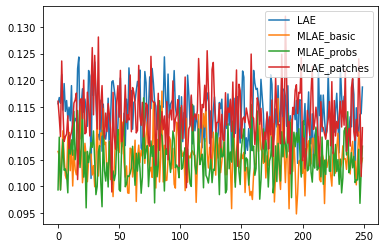

In [82]:
plt.plot(fe_loss_dict['LAE'])
plt.plot(fe_loss_dict['MLAE_basic'])
plt.plot(fe_loss_dict['MLAE_probs'])
plt.plot(fe_loss_dict['MLAE_patches'])
plt.legend(['LAE', 'MLAE_basic', 'MLAE_probs', 'MLAE_patches'])

In [83]:
fe_stats_dict = {'LAE': {'mean': statistics.mean(fe_loss_dict['LAE']), 'sd': statistics.stdev(fe_loss_dict['LAE'])},
                 'MLAE_basic': {'mean': statistics.mean(fe_loss_dict['MLAE_basic']), 'sd': statistics.stdev(fe_loss_dict['MLAE_basic'])},
                 'MLAE_probs': {'mean': statistics.mean(fe_loss_dict['MLAE_probs']), 'sd': statistics.stdev(fe_loss_dict['MLAE_probs'])},
                 'MLAE_patches': {'mean': statistics.mean(fe_loss_dict['MLAE_patches']), 'sd': statistics.stdev(fe_loss_dict['MLAE_patches'])}}
print(fe_stats_dict)

{'LAE': {'mean': 0.11375275256196264, 'sd': 0.004680703923231532}, 'MLAE_basic': {'mean': 0.10545459261278714, 'sd': 0.004082780960010285}, 'MLAE_probs': {'mean': 0.1052785675126907, 'sd': 0.004181136401924971}, 'MLAE_patches': {'mean': 0.11325677897093264, 'sd': 0.005184983288140111}}


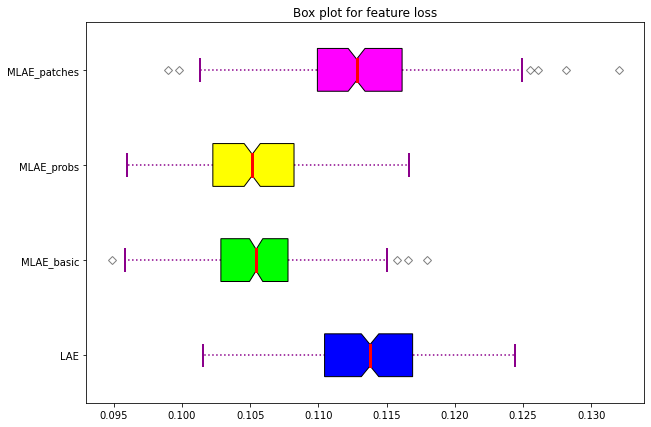

In [84]:
data = fe_loss_dict.values()
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 0)
 
colors = ['#0000FF', '#00FF00',
          '#FFFF00', '#FF00FF']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_yticklabels(fe_loss_dict.keys())
 
# Adding title
plt.title("Box plot for feature loss")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show()